<font color = green>

# Logistic Regression #
</font>

<font color = green>

## Import necessary packages

</font>

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import h5py # common package to interact with a dataset that is stored on an H5 file.
import scipy
# from PIL import Image
from scipy import ndimage
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

<font color = green>

## Problem statement ##
</font>


Dataset ("data.h5") contains:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB) (each image is square: height = num_px and width = num_px).

Task is to build a simple image-classification algorithm that can correctly classify pictures as cat or non-cat.

<font color = green>

## Overview dataset 

</font>

<font color = green>

### Create shortcut for path

</font>

In [2]:
import os
cwd = os.getcwd() # current working directory
path = os.path.join(cwd, 'data') 
print (path)

/home/taras/Стільниця/day/data_science/camp_2021/data_science_camp_2021_hometask/lesson_7_hometask_log_regr/data


<font color = green>

### Load dataset

</font>

In [3]:
def load_dataset():
    file_name =  os.path.join(path , 'train_catvnoncat.h5')
    train_dataset = h5py.File(file_name, "r")
    X_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    Y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels
    
    file_name=  os.path.join(path , 'test_catvnoncat.h5')
    test_dataset = h5py.File(file_name, "r")
    X_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    Y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = ['non-cat','cat']
    
    Y_train = Y_train.reshape(-1,1)
    Y_test = Y_test.reshape(-1,1)
    
    return X_train, Y_train, X_test, Y_test, classes

In [4]:
X_train, Y_train, X_test, Y_test, classes = load_dataset()

In [5]:
print('X_train.shape = ', X_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape)
print('Y_test.shape = ', Y_test.shape)

X_train.shape =  (209, 64, 64, 3)
X_test.shape =  (50, 64, 64, 3)
Y_train.shape =  (209, 1)
Y_test.shape =  (50, 1)


In [6]:
m_train = len(Y_train)
num_px = 64
m_test = len(Y_test)

In [7]:
print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)


<font color = green>

### Review some examples

</font>

y = [1], it's a 'cat' picture.


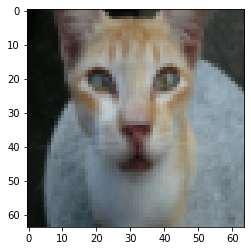

In [8]:
# Example of a picture
index = 11
plt.imshow(X_train[index])
print ("y = " + str(Y_train[index,:]) + ", it's a '" + classes[np.squeeze(Y_train[index,:])] +  "' picture.")

y = [0], it's a 'non-cat' picture.


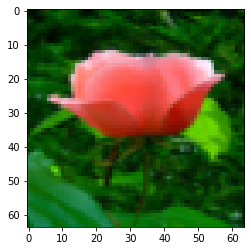

In [9]:
index = 3
plt.imshow(X_train[index])
print ("y = " + str(Y_train[index,:]) + ", it's a '" + classes[np.squeeze(Y_train[index,:])] +  "' picture.")

In [10]:
print('Label 1 count:', np.sum(Y_train!=0))
print('Label 0 count:', np.sum(Y_train==0))

Label 1 count: 72
Label 0 count: 137


<font color = green>

## Flatten features

</font>

In [11]:
# YOUR_CODE. Reshape the training and test set to shape (number_of_samples,  num_px*num_px*3)
X_train_flatten = X_train.reshape(209, 12288)
X_test_flatten =  X_test.reshape(50, 12288)

<font color = blue >

### Check result

</font>

In [12]:
print(f'train_set_x_flatten shape: {X_train_flatten.shape}')
print(f'test_set_x_flatten shape: {X_test_flatten.shape}')
print(f'sanity check after reshaping: {X_train_flatten[0, :5]}')

train_set_x_flatten shape: (209, 12288)
test_set_x_flatten shape: (50, 12288)
sanity check after reshaping: [17 31 56 22 33]


<font color = green>

## Normalize features

</font>
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

For picture datasets, it is almost the same as MinMaxScaler  to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [13]:
X_train_scaled = X_train_flatten / 255.
X_test_scaled = X_test_flatten / 255.

<font color = green>

## sigmoid function

</font>

$ g(z) = \frac{1}{1 + e^{-z}}$

In [14]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    g -- sigmoid(z)
    """

    g = 1 / (1 + np.exp(-z))
    
    return g

<font color = blue >

### Check result

</font>

In [15]:
print("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


<font color = green>

## Initialize parameters

</font>

In [16]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (1, dim) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (1, dim)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((1, dim))
    b = 0

    assert(w.shape == (1, dim))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

<font color = blue >

### Check result

</font>

In [17]:
dim = 2
w, b = initialize_with_zeros(dim)
print("w = " + str(w))
print("b = " + str(b))

w = [[0. 0.]]
b = 0


<font color = green>

##  Forward and Backward propagation

</font>


Computing cost function is called "forward" and computing derivatives (gradient) is called "backward" propagation

**Forward Propagation:**
- compute  $Z = b + X \,@\,  w.T  \quad([[z^{(0)}], [z^{(1)}], ..., [z^{(m-1)}]])$
- compute  $A = g(Z)  \quad([[a^{(0)}], [a^{(1)}], ..., [a^{(m-1)}]])$
- calculate the cost function: $J = -\frac{1}{m}\sum_{i=0}^{m-1}(y^{(i)}\log(a^{(i)})+(1-Y^{(i)})\log(1-a^{(i)}))$

**Backward Propagation:** 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}(A-Y)^T @X \quad \quad 
 \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [18]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y, C=1):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (1,num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (number of examples,1)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """
    m = X.shape[0]

    Z = b + X @ w.T
    A = sigmoid(Z)
    cost = -(1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
  
    dJ_dw = 1 / m * (A - Y).T @ X
    dJ_db = (1 / m * (A - Y)).sum()

    assert(dJ_dw.shape == w.shape)
    assert(dJ_db.dtype == float)
    assert(cost.dtype == float)
    
    grads = {
        "dJ_dw": dJ_dw,
        "dJ_db": dJ_db
    }
    
    return grads, cost

<font color = blue >

### Check result

</font>

In [19]:
w, b, X, Y = np.array([[1., 2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]).T, np.array([[1,0,1]]).T
grads, cost = propagate(w, b, X, Y)
print("dJ_dw = " + str(grads["dJ_dw"]))
print("dJ_db = " + str(grads["dJ_db"]))
print("cost = " + str(cost))

dJ_dw = [[0.99845601 2.39507239]]
dJ_db = 0.001455578136784208
cost = 5.801545319394553


<font color = green>

##   Optimization
</font>

In [20]:
def optimize(w, b, X, Y, num_iterations, learning_rate, C= 1, verbose = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (1,num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (number of examples,1)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
   
    costs = [] # keep history for plotting if necessary 
    
    for i in range(num_iterations):        

    
        # YOUR_CODE.  Call to compute cost and gradient 
        # START_CODE   
        grads, cost = None, None
        # END_CODE 
        
        # Retrieve derivatives from grads
        dJ_dw = grads["dJ_dw"]
        dJ_db = grads["dJ_db"]
        
        # YOUR_CODE.  Update paramaters 
        # START_CODE   
        w = None
        b = None
        # END_CODE 
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if verbose and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dJ_dw": dJ_dw,
             "dJ_db": dJ_db}
    
    return params, grads, costs

<font color = blue >

### Check result

</font>

In [21]:
# params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, verbose = False)

# print ("w = " + str(params["w"]))
# print ("b = " + str(params["b"]))
# print ("dw = " + str(grads["dJ_dw"]))
# print ("db = " + str(grads["dJ_db"]))

In [22]:
Y_test[index,0]

1

<font color = green>

##  Test with your image
</font>

image.size = (64, 64)


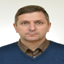

In [23]:
from PIL import Image
file_name = os.path.join(path , 'Oleksiy.Tsebriy.jpg')
image = Image.open(file_name).resize((num_px,num_px))
print('image.size =', image.size)
image

In [24]:
my_image = np.array(image.getdata())
my_image.shape

(4096, 3)

In [25]:
my_image = my_image.reshape((1, num_px*num_px*3))
print('my_image.shape =', my_image.shape)
my_image

my_image.shape = (1, 12288)


array([[227, 227, 217, ...,  43,  65,  96]])

In [26]:
# my_predicted_image = predict(res["w"], res["b"], my_image)
# my_predicted_image
# print('y = {} , your algorithm predicts a {} picture.'.
#       format(np.squeeze(my_predicted_image),classes[np.squeeze(my_predicted_image)]))

image.size = (64, 64)


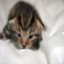

In [27]:
file_name = os.path.join(path , 'test_cat.jpg')
image = Image.open(file_name).resize((num_px,num_px))
print('image.size =', image.size)
image

In [28]:
# my_image = np.array(image.getdata())[:,:3] # by unknown reason picture made as screenshot has 4 channels 
# print('my_image.shape =', my_image.shape)
# my_image = my_image.reshape((1, num_px*num_px*3))
# print('after reshape: my_image.shape =', my_image.shape)
# my_predicted_image = predict(res["w"], res["b"], my_image)

# print('y = {} , your algorithm predicts a {} picture.'.
#       format(np.squeeze(my_predicted_image),classes[np.squeeze(my_predicted_image)]))

<font color = green>

##  Sklearn implementation
</font>

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
y_train = np.squeeze(Y_train) # LogisticRegression requires 1d input for y
clf = LogisticRegression(C=0.01).fit(X_train_scaled, y_train)

In [31]:
print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
y_test = np.squeeze(Y_test)
print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))

train accuracy= 90.909%
test accuracy= 66.000%


In [32]:
print('y = {}, sklearn algorithm predicts a {} picture.'.
      format(np.squeeze(clf.predict(my_image)), classes[np.squeeze(clf.predict(my_image))]))

y = 0, sklearn algorithm predicts a non-cat picture.


<font color = green>

##  Sklearn for brest cancer dataset 
</font>

In [33]:
# load and split data
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer)

In [34]:
# normalization data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
clf = LogisticRegression(C=1, max_iter=100000).fit(X_train_scaled, y_train)
print('\nBreast cancer dataset')
print(f'X_cancer.shape = {X_cancer.shape}')
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))


Breast cancer dataset
X_cancer.shape = (569, 30)
Accuracy of Logistic regression classifier on training set: 0.99
Accuracy of Logistic regression classifier on test set: 0.96


<font color = green>

##  Sklearn for synthetic dataset 
</font>

<font color = green>

###  Additional functions for visualization
</font>

In [36]:
# %matplotlib notebook

In [49]:
def plot_decision_boundary(clf, X_train, y_train, X_test=None, y_test=None, title=None, precision=0.01, plot_symbol_size=50, ax=None, is_extended=True):

    '''    
    Draws the binary decision boundary for X that is nor required additional features and 
    transformation (like polynomial)
    '''
    # Create color maps - required by pcolormesh
    from matplotlib.colors import  ListedColormap
    colors_for_points = np.array(['grey', 'orange']) # neg/pos
    colors_for_areas = np.array(['grey', 'orange']) # neg/pos  # alpha is applied later 
    cmap_light = ListedColormap(colors_for_areas)
    

 
    
    mesh_step_size = precision #.01  # step size in the mesh
    if X_test is None or y_test is None:
        show_test= False
        X= X_train
    else:
        show_test= True
        X= np.concatenate([X_train,X_test], axis=0)
    x1_min, x1_max = X[:, 0].min() - .1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - .1, X[:, 1].max() + 0.1
    # Create grids of pairs
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, mesh_step_size),
                         np.arange(x2_min, x2_max, mesh_step_size))
    # Flatten all samples 
    target_samples_grid= (np.c_[xx1.ravel(), xx2.ravel()])

    print ('Call prediction for all grid values (precision of drawing = {},\n you may configure to speed up e.g. precision=0.05)'.format(precision))
    Z = clf.predict(target_samples_grid)

    # Reshape the result to original meshgrid shape 
    Z = Z.reshape(xx1.shape)
    
    if ax:
        plt.sca(ax)
    
    # Plot all meshgrid prediction      
    plt.pcolormesh(xx1, xx2, Z, cmap=cmap_light, alpha=0.2, shading='auto')

    # Plot train set
    plt.scatter(X_train[:, 0], X_train[:, 1], s=plot_symbol_size, 
                c=colors_for_points[y_train.ravel()], edgecolor = 'black',alpha=0.6)
    # Plot test set
    if show_test:
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='^', s=plot_symbol_size, 
                c=colors_for_points[y_test.ravel()],edgecolor = 'black',alpha=0.6)
    if  is_extended:
        # Create legend  
        import matplotlib.patches as mpatches # use to assign lavels for colored points 
        patch0 = mpatches.Patch(color=colors_for_points[0], label='negative')
        patch1 = mpatches.Patch(color=colors_for_points[1], label='positive')
        plt.legend(handles=[patch0, patch1])
    plt.title(title)
    if is_extended:
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
    else:
        plt.tick_params(
        top =False,
        bottom= False,
        left  = False,
        labelleft = False, 
        labelbottom = False
        )

   
    
def plot_data_logistic_regression(X,y,legend_loc= 1, title= None):
    '''
    :param X: 2 dimensional ndarray
    :param y:  1 dimensional ndarray. Use y.ravel() if necessary
    :return:
    '''

    positive_indices = (y == 1)
    negative_indices = (y == 0)
#     import matplotlib as mpl
    colors_for_points = ['grey', 'orange'] # neg/pos

    plt.scatter(X[negative_indices][:,0], X[negative_indices][:,1], s=40, c=colors_for_points [0], edgecolor = 'black', label='negative', alpha = 0.7)
    plt.scatter(X[positive_indices][:,0], X[positive_indices][:,1], s=40, c=colors_for_points [1], edgecolor = 'black',label='positive', alpha = 0.7)
    plt.title(title)
    plt.legend(loc= legend_loc)



<font color = green>

###  Make classification
</font>

In [38]:
Xc_2, yc_2 = make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    random_state=2018,
    n_clusters_per_class=1,
    flip_y=0.1,
    class_sep=0.8
)

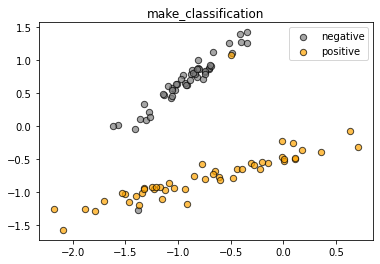

In [39]:
plt.figure()    
plot_data_logistic_regression(Xc_2, yc_2, title='make_classification')

In [43]:
C = 1000
X_train, X_test, y_train, y_test = train_test_split(Xc_2, yc_2, random_state = 0)
clf = LogisticRegression(C=C).fit(X_train, y_train)
print('Make Regression')
print(f'Xc_2.shape = {Xc_2.shape}')
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Make Regression
Xc_2.shape = (100, 2)
Accuracy of Logistic regression classifier on training set: 0.99
Accuracy of Logistic regression classifier on test set: 0.92


Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)


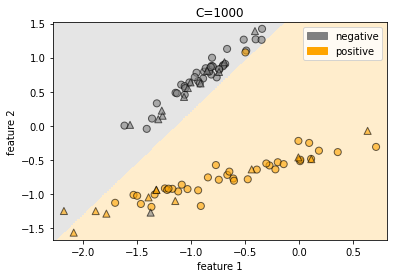

In [51]:
plt.figure()    
plot_decision_boundary(
    clf,
    X_train,
    y_train,
    X_test,
    y_test,
    title=f'C={C}',
    precision=0.01,
    plot_symbol_size=50
)

Accuracy = 0.57
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.97
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.99
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.99
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.99
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.99
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)


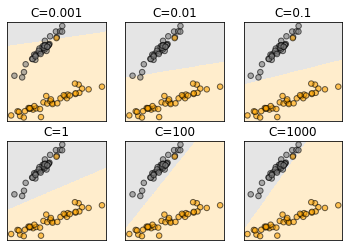

In [53]:
_, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
axes = (ax1, ax2, ax3, ax4, ax5, ax6)
C = (0.001, 0.01, 0.1, 1, 100, 1000)
for i in range (len(C)):    
    clf = LogisticRegression(C=C[i]).fit(X_train, y_train)
    print('Accuracy = {:.2f}'.format(clf.score(X_train, y_train)))
    plot_decision_boundary(
        clf,
        X_train,
        y_train,
        title=f'C={C[i]}',
        precision=0.01,
        plot_symbol_size=30,
        ax= axes[i],
        is_extended=False
    )

<font color = green>

## Polynomial In Logistic Regression

</font>

<font color = green>

###  Additional functions for visualization
</font>

In [55]:
def plot_decision_boundary(clf, X_train, y_train, X_test=None, y_test= None, title=None, precision=0.05,plot_symbol_size = 50, ax= None,  is_extended=True):

    '''    
    Draws the binary decision boundary for X that is nor required additional features and transformation (like polynomial)
    '''
    # Create color maps - required by pcolormesh
    from matplotlib.colors import  ListedColormap
    colors_for_points = np.array(['grey', 'orange']) # neg/pos
    colors_for_areas = np.array(['grey', 'orange']) # neg/pos  # alpha is applied later 
    cmap_light = ListedColormap(colors_for_areas)
    

 
    
    mesh_step_size = precision #.01  # step size in the mesh
    if X_test is None or y_test is None:
        show_test= False
        X= X_train
    else:
        show_test= True
        X= np.concatenate([X_train,X_test], axis=0)
    x1_min, x1_max = X[:, 0].min() - .1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - .1, X[:, 1].max() + 0.1
    # Create grids of pairs
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, mesh_step_size),
                         np.arange(x2_min, x2_max, mesh_step_size))
    # Flatten all samples 
    target_samples_grid= (np.c_[xx1.ravel(), xx2.ravel()])

    print ('Call prediction for all grid values (precision of drawing = {},\n you may configure to speed up e.g. precision=0.05)'.format(precision))
    Z = clf.predict(target_samples_grid)

    # Reshape the result to original meshgrid shape 
    Z = Z.reshape(xx1.shape)
    
    if ax:
        plt.sca(ax)
    
    # Plot all meshgrid prediction      
    plt.pcolormesh(xx1, xx2,Z, cmap = cmap_light, alpha=0.2)

    # Plot train set
    plt.scatter(X_train[:, 0], X_train[:, 1], s=plot_symbol_size, 
                c=colors_for_points[y_train.ravel()], edgecolor = 'black',alpha=0.6)
    # Plot test set
    if show_test:
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='^', s=plot_symbol_size, 
                c=colors_for_points[y_test.ravel()],edgecolor = 'black',alpha=0.6)
    if  is_extended:
        # Create legend  
        import matplotlib.patches as mpatches # use to assign lavels for colored points 
        patch0 = mpatches.Patch(color=colors_for_points[0], label='negative')
        patch1 = mpatches.Patch(color=colors_for_points[1], label='positive')
        plt.legend(handles=[patch0, patch1])
    plt.title(title)
    if is_extended:
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
    else:
        plt.tick_params(
        top =False,
        bottom= False,
        left  = False,
        labelleft = False, 
        labelbottom = False
        )

def plot_decision_boundary_poly(clf, X_train, y_train, degree, X_test=None, y_test= None, title=None, precision=0.05,plot_symbol_size = 50, ax= None,  is_extended=True):

    '''    
    Draws the binary decision boundary for X that is nor required additional features and transformation (like polynomial)
    '''
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree,include_bias=False)
    
    # Create color maps - required by pcolormesh
    from matplotlib.colors import  ListedColormap    
    colors_for_points = np.array(['grey', 'orange']) # neg/pos
    colors_for_areas = np.array(['grey', 'orange']) # neg/pos  # alpha is applied later 
    cmap_light = ListedColormap(colors_for_areas)
    

 
    
    mesh_step_size = precision #.01  # step size in the mesh
    if X_test is None or y_test is None:
        show_test= False
        X= X_train
    else:
        show_test= True
        X= np.concatenate([X_train,X_test], axis=0)
    x1_min, x1_max = X[:, 0].min() - .1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - .1, X[:, 1].max() + 0.1
    # Create grids of pairs
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, mesh_step_size),
                         np.arange(x2_min, x2_max, mesh_step_size))
    # Flatten all samples 
    target_samples_grid= (np.c_[xx1.ravel(), xx2.ravel()])
    target_samples_grid_poly = poly.fit_transform(target_samples_grid)
    print ('Call prediction for all grid values (precision of drawing = {},\n you may configure to speed up e.g. precision=0.05)'.format(precision))
    Z = clf.predict(target_samples_grid_poly)
    print ('Computing prediction completed.')
    # Reshape the result to original meshgrid shape 
    Z = Z.reshape(xx1.shape)
    
    if ax:
        plt.sca(ax)
    
    # Plot all meshgrid prediction      
    plt.pcolormesh(xx1, xx2,Z, cmap = cmap_light, alpha=0.2)

    # Plot train set
    plt.scatter(X_train[:, 0], X_train[:, 1], s=plot_symbol_size, 
                c=colors_for_points[y_train.ravel()], edgecolor = 'black',alpha=0.6)
    # Plot test set
    if show_test:
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='^', s=plot_symbol_size, 
                c=colors_for_points[y_test.ravel()],edgecolor = 'black',alpha=0.6)
    if  is_extended:
        # Create legend  
        import matplotlib.patches as mpatches # use to assign lavels for colored points 
        patch0 = mpatches.Patch(color=colors_for_points[0], label='negative')
        patch1 = mpatches.Patch(color=colors_for_points[1], label='positive')
        plt.legend(handles=[patch0, patch1])
    plt.title(title)
    if is_extended:
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
    else:
        plt.tick_params(
        top =False,
        bottom= False,
        left  = False,
        labelleft = False, 
        labelbottom = False
        )

   
        
    
def plot_data_logistic_regression(X,y,legend_loc= None, title= None):
    '''
    :param X: 2 dimensional ndarray
    :param y:  1 dimensional ndarray. Use y.ravel() if necessary
    :return:
    '''

    positive_indices = (y == 1)
    negative_indices = (y == 0)
#     import matplotlib as mpl
    colors_for_points = ['grey', 'orange'] # neg/pos

    plt.scatter(X[negative_indices][:,0], X[negative_indices][:,1], s=40, c=colors_for_points [0], edgecolor = 'black', label='negative', alpha = 0.7)
    plt.scatter(X[positive_indices][:,0], X[positive_indices][:,1], s=40, c=colors_for_points [1], edgecolor = 'black',label='positive', alpha = 0.7)
    plt.title(title)
    plt.legend(loc= legend_loc)

def plot_multi_class_logistic_regression(X,y,dict_names=None, colors= None,  title =None):
    '''
    Draw the multi class samples of 2 features
    :param X: X 2 ndarray (m,2),
    :param y: vector (m,)
    :param dict_names: dict of values of y and names
    :return: None
    '''
    if not colors:
        colors_for_points = ['green','grey', 'orange', 'brown'] 
    else: 
         colors_for_points = colors 
            
    y_unique = list(set(y))

    for i in range (len(y_unique)):
        ind = y == y_unique[i] # vector

        if dict_names:
            plt.scatter(X[ind,0], X[ind,1], c=colors_for_points[i], s=40, label=dict_names[y_unique[i]],edgecolor='black', alpha=.7)
        else:
            plt.scatter(X[ind, 0], X[ind, 1], s=40, c=colors_for_points [i], edgecolor = 'black', alpha = 0.7)
    if title:
        plt.title(title)

    if dict_names:
        plt.legend(frameon=True)

def draw_linear_decision_boundaries_multiclass(clf,X,):
    colors=  ['green','grey', 'orange', 'brown'] 
    x_line = np.linspace(X[:,0].min(),X[:,0].max(), 100)
    for w, b, color in zip(clf.coef_, clf.intercept_, colors):
        # Since class prediction with a linear model uses the formula y = w_0 x_0 + w_1 x_1 + b,
        # and the decision boundary is defined as being all points with y = 0, to plot x_1 as a
        # function of x_0 we just solve w_0 x_0 + w_1 x_1 + b = 0 for x_1:
        y_line = -(x_line  * w[0] + b) / w[1]
        ind = (X[:,0].min()< x_line) & (x_line <X[:,0].max()) & (X[:,1].min()< y_line) & (y_line <X[:,1].max() )
        plt.plot(x_line[ind] , y_line[ind], '-', c=color, alpha=.8)


In [57]:
X_mk8, y_mk8 = make_blobs(n_samples = 200, n_features = 2, centers = 8, # centers impacts for y 
                       cluster_std = 1.3, random_state = 4)
y_train = y_mk8 % 2 # make it binary since make_blobs  with centers = 8 creates y in [0..7]

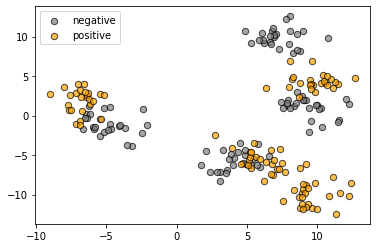

In [58]:
plt.figure()
plot_data_logistic_regression(X_mk8, y_train)